In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import statistics as sts
from lmfit import Model
from scipy.stats import sem

In [8]:
#Functions

# Linear Fit
def line(x, m, b):
    return x * m + b
gmodel = Model(line)
param = gmodel.make_params()

# Resistance as a function of area of test structures
def idea_res(s, sigma):
    return s / (sigma * 0.2 * (60 * 5 + (60 - 1) * (2 * s + 3200))) # Check units \sigma = S cm-1
    # return s / (sigma * d * (N * W + (W - 1) * (2 * s + L)))

gmodel2 = Model(idea_res)
param2 = gmodel2.make_params(sigma = 5e-9)

In [9]:
# Questions
plot = input('Plot?')
save = input('Save?')
f = input('Include linear fit?')
table = input('Make table?')

# Variables
split = 'LSB_07'
metals = {'0G_13': 'Pt',
          '0G_14' : 'Al',
          '0G_15' : 'Mo',
          '0G_16' : 'Cr',
        }
measurements = {'Pt' : {},
                'Al' : {},
                'Mo' : {},
                'Cr' : {}
                }

# Folder where the files are
data_path = os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split, 'LCR')
dict = {}
r_dict = {}
row_names = []
for i in os.listdir(data_path):
    files = os.listdir(os.path.join(data_path, i))
    for j in files:
        row_names.append(metals[i] + ' ' + j[:-4])
        data = pd.read_csv(os.path.join(data_path, i, j))
        dict[j] = (data['DC'], data['Idc'], data['Vds'])
        result = gmodel.fit(dict[j][1], param, m = 1, b = 1, x = dict[j][2])
        resistance = np.round(1 / result.values['m'], decimals = 2)
        r_square = 1 - result.residual.var() / np.var(dict[j][1])
        r_dict[metals[i] + ' ' + j[:-4]] = (float(resistance))
        measurements[metals[i]][j[:-4]] = (dict[j], resistance, r_square)
        
        if plot == 'y':

            fig, ax = plt.subplots(dpi = 400, facecolor = 'white')
            ax.set_title(metals[i] + ' ' + i + ' ' + j[:-4])
            ax.set_xlabel('Potential Vds (V)')
            ax.set_ylabel('Current Ids (A)')
            ax.scatter(dict[j][2], dict[j][1], s = 1, label = 'Measurement')
            ax.legend(markerscale = 5)

            if save == 'y':
                plt.savefig(os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split,
                            'Plots', i, metals[i] + ' ' + j[:-4]) + '.png', facecolor = 'white',  bbox_inches='tight')

            if f == 'y':

                fig, ax = plt.subplots(dpi = 400, facecolor = 'white')
                ax.set_title(metals[i] + ' ' + i + ' ' + j[:-4])
                ax.set_xlabel('Potential Vds (V)')
                ax.set_ylabel('Current Ids (A)')
                ax.scatter(dict[j][2], dict[j][1], s = 1, label = 'Measurement')
                ax.plot(dict[j][2], result.best_fit, alpha = 0.5, label = 'Linear Fit')
                ax.plot([],[], ' ', label = '{:.2f}'.format(resistance) + ' $\Omega$')
                ax.plot([],[], ' ', label = 'r$^2$ = ' + '{:.5f}'.format(r_square))
                ax.legend(markerscale = 5)

                if save == 'y':
                    plt.savefig(os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split,
                            'Plots', i, 'Fit_' + metals[i] + ' ' + j[:-4]) + '.png', facecolor = 'white',  bbox_inches='tight')
# resistance_data = pd.DataFrame(list(r_dict.values()), columns = ['Resistance (Ω)'], index = r_dict.keys())
# if table == 'y':
#     fig, ax = plt.subplots()
#     ax.axis('off')
#     t = ax.table(cellText=resistance_data.items, cellLoc='center', colLabels= ['Sample', 'Resistance ($\Omega$)'])
#     if save == 'y':
#         plt.savefig(os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split,
#                             'Plots', i, 'Table_Resistance ') + '.png', facecolor = 'white',  bbox_inches='tight')


{'Pt': [22202.35, 49281.18, 151809.77], 'Al': [73906.24, 312842.44, 162392.9], 'Mo': [54724.1, 96934.54, 134908.08], 'Cr': [5662.92, 45958.19, 76350.21]}


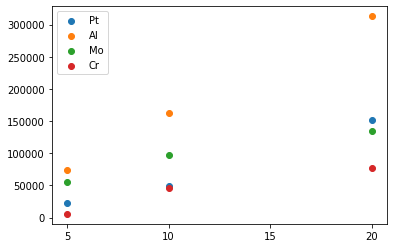

In [103]:
#Plot

fig, ax = plt.subplots(facecolor = 'white')
ax.set_xticks([5, 10, 15, 20])
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
q = {} #filter P02, P03 and P04
w = {} #get resistance values in a list for each metal
spacing = {'P02' : 5,
           'P03' : 10,
           'P04' : 20
           }

#plt.yticks(fontsize=5)
for i in measurements.keys():
    q[i] = {}
    for j in measurements[i].keys():
        r_kohm = measurements[i][j][1] # / 1000
        if 'P02' in j[3:]:
            q[i]['P02'] = r_kohm
        if 'P03' in j[3:]:
            q[i]['P03'] = r_kohm
        if 'P04' in j[3:]:
            q[i]['P04'] = r_kohm

n = 0
y_Pt = []
for i in q.keys():
    w[i] = []
    for j in q[i].keys():
        ax.scatter(spacing[j], q[i][j], color = colors[n])
        w[i].append( q[i][j])
    n += 1    

ax.legend([i for i in q.keys()])
for i in range(0,4):
    ax.get_legend().legendHandles[i].set_color(colors[i])

x = spacing.values()


print(w)

#backup

# for i in q['Pt'].keys():
#     ax.scatter(spacing[i], q['Pt'][i], color = 'tab:blue')
# for i in q['Al'].keys():
#     ax.scatter(spacing[i], q['Al'][i], color = 'tab:orange')
# for i in q['Mo'].keys():
#     ax.scatter(spacing[i], q['Mo'][i], color = 'tab:green')
# for i in q['Cr'].keys():
#     ax.scatter(spacing[i], q['Cr'][i], color = 'tab:red')


2.62e+08
6.01e+08
2.87e+08
1.54e+08
--------------------------
3.26e+08 96067210.59196514
Relative standard error: 29.48061993701859 %


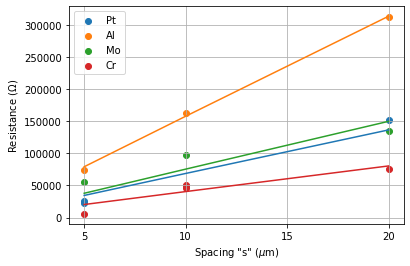

In [5]:
IDEA = {'P02' : {'S':5, 'W':5, 'L':3200, 'N':60},
        'P03' : {'S':10, 'W':5, 'L':3200, 'N':60},
        'P04' : {'S':20, 'W':5, 'L':3200, 'N':60},
        'P07' : {'S':10, 'W':5, 'L':5000, 'N':260},
        'P08' : {'S':20, 'W':5, 'L':5000, 'N':260},
        'P12' : {'S':5, 'W':5, 'L':3200, 'N':20},
        'P13' : {'S':5, 'W':5, 'L':3200, 'N':120},
        'P14' : {'S':5, 'W':5, 'L':3200, 'N':260},
        }



x_Pt, y_Pt, x_Al, y_Al, x_Mo, y_Mo, x_Cr, y_Cr = [], [], [], [], [], [], [], []

resist_dict = {'P02':[], 'P03':[], 'P04':[]}

for j in measurements.keys():
    for i in measurements[j].keys():
        if 'P02' in i:
            resist_dict['P02'].append((j, measurements[j][i][1]))
        elif 'P03' in i:
            resist_dict['P03'].append((j, measurements[j][i][1]))
        elif 'P04' in i:
            resist_dict['P04'].append((j, measurements[j][i][1]))

for i in resist_dict.keys():
    for j in resist_dict[i]:
        if j[0] == 'Pt':
            x_Pt.append(IDEA[i]['S'])
            y_Pt.append(j[1])
        if j[0] == 'Al':
            x_Al.append(IDEA[i]['S'])
            y_Al.append(j[1])
        if j[0] == 'Mo':
            x_Mo.append(IDEA[i]['S'])
            y_Mo.append(j[1])
        if j[0] == 'Cr':
            x_Cr.append(IDEA[i]['S'])
            y_Cr.append(j[1])

fit_Pt, fit_Al, fit_Mo, fit_Cr = gmodel2.fit(y_Pt, param2, s = x_Pt), gmodel2.fit(y_Al, param2, s = x_Al), gmodel2.fit(y_Mo, param2, s = x_Mo), gmodel2.fit(y_Cr, param2, s = x_Cr)

fig, ax = plt.subplots(facecolor = 'white')
ax.set_ylabel('Resistance ($\Omega$)')
ax.set_xlabel('Spacing "s" ($\mu$m)')
ax.set_xticks([0,5,10, 15, 20])

ax.scatter(x_Pt, y_Pt, color = 'tab:blue', label = 'Pt')
ax.scatter(x_Al, y_Al, color = 'tab:orange', label = 'Al')
ax.scatter(x_Mo, y_Mo, color = 'tab:green', label = 'Mo')
ax.scatter(x_Cr, y_Cr, color = 'tab:red', label = 'Cr')


#Fit
ax.plot(x_Pt, fit_Pt.best_fit, color = 'tab:blue')
ax.plot(x_Al, fit_Al.best_fit, color = 'tab:orange')
ax.plot(x_Mo, fit_Mo.best_fit, color = 'tab:green')
ax.plot(x_Cr, fit_Cr.best_fit, color = 'tab:red')

ax.legend()
ax.grid()
resistivity = [1 / fit_Pt.values['sigma'], 1 / fit_Al.values['sigma'], 1 / fit_Mo.values['sigma'], 1 / fit_Cr.values['sigma']]
mean = sts.mean(resistivity)
stand_err = sem(resistivity)
for i in resistivity:
    print('{:.2e}'.format(i))
print('--------------------------')
print('{:.2e}'.format(mean), stand_err)
print('Relative standard error: ' + str(stand_err / mean * 100) + ' %')


In [6]:
# graph = {'Pt' : {5 : [], 10: [], 20: []},
#          'Al' : {5 : [], 10: [], 20: []},
#          'Mo' : {5 : [], 10: [], 20: []},
#          'Cr' : {5 : [], 10: [], 20: []}
#          }
# pt = []

# for j in metals.values():
#     for i in resistance_table.index:
#         if j in i:
#             if 'P02' in i:
#                 graph[j][5].append(resistance_table.xs(i)[0])
#             elif 'P03' in i:
#                 graph[j][10].append(resistance_table.xs(i)[0])
#             elif 'P04' in i:
#                 graph[j][20].append(resistance_table.xs(i)[0])    
# #print(graph)
# df = pd.DataFrame(graph.values(), columns=[5,10,20], index = ['Pt', 'Al', 'Mo', 'Cr']) #, index = r_dict.keys())p
# print(df[5])
# plt.scatter([5,5,5,5], df[5])
# #for i in resistance_table['Sample']:
# #     if 'P02' in i:
# #         resistance_table.loc[i]
# #resistance_table
#resistance_table.xs('Pt C1_P02')